In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import torch

from CustomCoordCheck import generate_SSM_models

# df = pd.read_pickle('/home/berlin/mup/coord_checks/μp_ssm_sgd_lr0.1_nseeds40_bn0_coord_4Jul2024.pkl')

# df.to_csv('/home/berlin/mup/coord_checks/μp_ssm_sgd_lr0.1_nseeds40_bn0_coord_4Jul2024.csv')

# print(df[(df['t'] == 3) & (df['width'] == 1700) & (df['module'] == 'kernel')].to_string())


df_B = {'seed':[], 'B': [], 't': []}
df_C = {'seed':[], 'C': [], 't': []}
def record_BC(B, C, seed, t):
    B, C = B.squeeze(), model.kernel.C.squeeze()
    B, C = B.detach().numpy().tolist(), C.detach().numpy().tolist()
    if type(B) is not list:
        B = [B]
    if type(C) is not list:
        C = [C]
    for b in B:
        df_B['seed'].append(seed)
        df_B['B'].append(b)
        df_B['t'].append(t)

    for c in C:
        df_C['seed'].append(seed)
        df_C['C'].append(c)
        df_C['t'].append(t)

# Load the rng that's causing activation spike:
rng_seed = torch.load('/home/berlin/mup/coord_checks/rng_state_1700_5July2024.pt')
torch.set_rng_state(rng_seed)

# #Load a 'normal' seed state
# torch.manual_seed(1)

# Initialize the model with such seed:
model = generate_SSM_models([1700], mup=True)[1700]()
record_BC(model.kernel.B, model.kernel.C, seed='rougue', t=0)





# torch.manual_seed(0)
# model = generate_SSM_models([1700], mup=True)[1700]()
# record_BC(model.kernel.B, model.kernel.C, seed='normal')




/home/berlin/miniconda3/envs/ssm/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import torch.nn.functional as F
from mup.optim import MuSGD as SGD
from CustomCoordCheck import get_train_loader

nsteps = 3
lr = 0.1

l1_func = lambda x: torch.abs(x).mean(dtype=torch.float32)

optcls = lambda model: SGD(model.parameters(), lr=lr)
optimizer = optcls(model)

dataloader = get_train_loader(batch_size=1, num_workers=0, shuffle=False, train=True, download=True) 
batch = next(iter(dataloader))
dataloader = [batch] * nsteps

model = model.train()
for batch_idx, batch in enumerate(dataloader, 1):
    (data, target) = batch
    output = model(data)
    # target = F.one_hot(target,
    #                     num_classes=output.size(-1)).float()
    print(f"DEBUG: output is {output}")
    loss = F.cross_entropy(output, target)

    # print(f"target.size() is {target.size()}")

    # print(f"output is {output}, target is {target}, loss is {loss}; A is {model.kernel.A}")
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    record_BC(model.kernel.B, model.kernel.C, seed='rougue', t=batch_idx)

    print(f"l1_func(output) is {l1_func(output)}")
    print(f"l1_func(model.up_project.weight) is {l1_func(model.up_project.weight)}")
    print(f"l1_func(model.up_project.bias) is {l1_func(model.up_project.bias)}")
    print(f"l1_func(model.kernel.A) is {l1_func(model.kernel.A)}")
    print(f"l1_func(model.kernel.B) is {l1_func(model.kernel.B)}")
    print(f"l1_func(model.kernel.C) is {l1_func(model.kernel.C)}")
    print(f"l1_func(model.down_project.weight) is {l1_func(model.down_project.weight)}")
    print(f"l1_func(model.down_project.bias) is {l1_func(model.down_project.bias)}")


# record_BC(model.kernel.B, model.kernel.C, seed='rougue')

Files already downloaded and verified
DEBUG: output is tensor([[-219.7935, -219.7935, -219.7935, -219.7935, -219.7935, -219.7935,
         1978.1417, -219.7935, -219.7935, -219.7935]],
       grad_fn=<AddmmBackward0>)
l1_func(output) is 395.62835693359375
l1_func(model.up_project.weight) is 0.29061082005500793
l1_func(model.up_project.bias) is 0.29124680161476135
l1_func(model.kernel.A) is 0.6956562995910645
l1_func(model.kernel.B) is 0.31654995679855347
l1_func(model.kernel.C) is 0.21071189641952515
l1_func(model.down_project.weight) is 1.2895045280456543
l1_func(model.down_project.bias) is 0.017999999225139618
DEBUG: output is tensor([[-219.7935, -219.7935, -219.7935, -219.7935, -219.7935, -219.7935,
         1978.1417, -219.7935, -219.7935, -219.7935]],
       grad_fn=<AddmmBackward0>)
l1_func(output) is 395.62835693359375
l1_func(model.up_project.weight) is 0.29061082005500793
l1_func(model.up_project.bias) is 0.29124680161476135
l1_func(model.kernel.A) is 0.6956562995910645
l1_fun

<Axes: xlabel='B', ylabel='Count'>

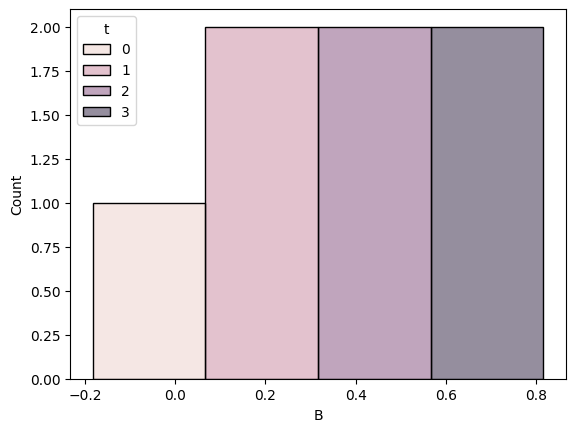

In [5]:
import seaborn as sns
# Plot parameters A, B, and C

sns.histplot(data=df_B, x='B', multiple='dodge', alpha=0.5, hue='t')

In [7]:
model.kernel.A.grad

tensor([[0.]])